In [52]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [59]:
import os
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler

# Configuración general
folder_path = r"C:\Users\Ibon\PycharmProjects\Microgrid\TrainTestSplit"
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# Separar archivos de train y test
train_files = [f for f in csv_files if "train" in f]
test_files = [f for f in csv_files if "test" in f]

def load_data(files, fraction=0.1):
    df_list = []
    for file in files:
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path, parse_dates=["Time Stamp (local standard time) yyyy-mm-ddThh:mm:ss"])
        df = df.drop(columns='Time Stamp (local standard time) yyyy-mm-ddThh:mm:ss')
        df_sampled = df.sample(frac=fraction, random_state=42)  # Tomar solo el 10% de las filas
        df_list.append(df_sampled)
    return pd.concat(df_list, ignore_index=True)

# Cargar datos (solo el 10% de cada archivo)
train_df = load_data(train_files, fraction=0.4)
test_df = load_data(test_files, fraction=0.4)

# Separar en X (features) e y (target)
numerical_cols = train_df.columns.drop(['Pmp (W)', 'source']).tolist()
X_train_num = train_df[numerical_cols].values.astype(np.float32)
X_test_num = test_df[numerical_cols].values.astype(np.float32)

# Escalar características numéricas
scaler_num = StandardScaler()
X_train = scaler_num.fit_transform(X_train_num)
X_test = scaler_num.transform(X_test_num)
y_train = train_df['Pmp (W)'].values.astype(np.float32)
y_test = test_df['Pmp (W)'].values.astype(np.float32)

# Convertir a tensores de PyTorch
X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train).unsqueeze(1)
X_test_tensor = torch.tensor(X_test)
y_test_tensor = torch.tensor(y_test).unsqueeze(1)


In [60]:
# Definir el modelo DNN
class DNN(nn.Module):
    def __init__(self, input_dim):
        super(DNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(128, 64),
            nn.ReLU(),
            
            nn.Linear(64, 1)
        )
    
    def forward(self, x):
        return self.model(x)

# Configuración del modelo
input_dim = X_train.shape[1]
model = DNN(input_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

DNN(
  (model): Sequential(
    (0): Linear(in_features=9, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=128, out_features=64, bias=True)
    (13): ReLU()
    (14): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [61]:
# Configuración del entrenamiento
batch_size = 512
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.3)
criterion = nn.MSELoss()

# Entrenamiento con early stopping
epochs = 200
best_loss = np.inf
patience = 15
counter = 0
train_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
    
    avg_loss = running_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)
    scheduler.step(avg_loss)
    
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")
    
    # Early stopping
    if avg_loss < best_loss:
        best_loss = avg_loss
        counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        counter += 1
        if counter >= patience:
            print(f"⏹️ Early stopping at epoch {epoch+1}")
            break

Epoch [1/200], Loss: 826.7697
Epoch [2/200], Loss: 661.9057
Epoch [3/200], Loss: 658.6400
Epoch [4/200], Loss: 657.0967
Epoch [5/200], Loss: 655.3133
Epoch [6/200], Loss: 655.3713
Epoch [7/200], Loss: 652.8681
Epoch [8/200], Loss: 653.4216
Epoch [9/200], Loss: 653.2851
Epoch [10/200], Loss: 652.0139
Epoch [11/200], Loss: 651.0254
Epoch [12/200], Loss: 651.1027
Epoch [13/200], Loss: 650.7355
Epoch [14/200], Loss: 651.2795
Epoch [15/200], Loss: 649.8229
Epoch [16/200], Loss: 649.7555
Epoch [17/200], Loss: 648.5435
Epoch [18/200], Loss: 649.6896
Epoch [19/200], Loss: 648.3502
Epoch [20/200], Loss: 648.2219
Epoch [21/200], Loss: 648.3924
Epoch [22/200], Loss: 647.9209
Epoch [23/200], Loss: 647.5871
Epoch [24/200], Loss: 647.4810
Epoch [25/200], Loss: 646.8934
Epoch [26/200], Loss: 646.9786
Epoch [27/200], Loss: 646.5226
Epoch [28/200], Loss: 646.6489
Epoch [29/200], Loss: 645.6864
Epoch [30/200], Loss: 646.4944
Epoch [31/200], Loss: 644.9190
Epoch [32/200], Loss: 645.9260
Epoch [33/200], L

C:\Users\Ibon\AppData\Local\Temp\ipykernel_24328\1779369219.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))



📊 Test MSE: 623.5474
📏 Test MAE: 15.3255
📈 Test R2: 0.5621


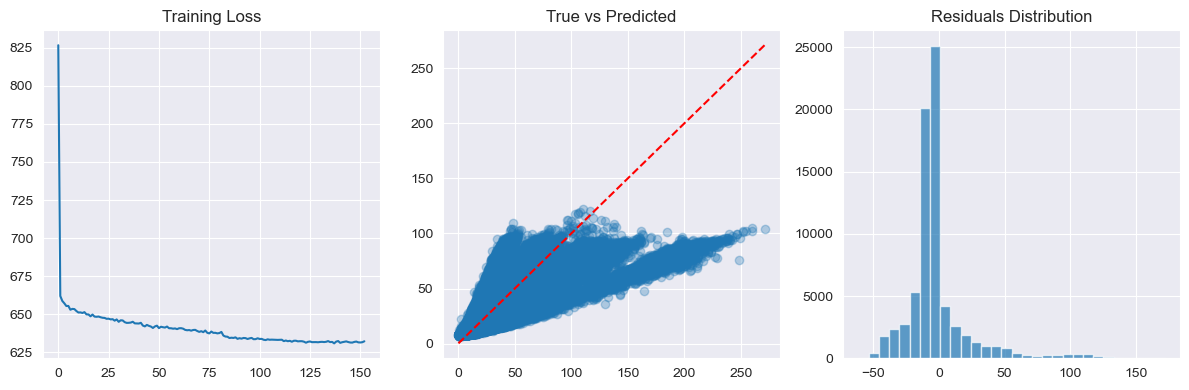

In [62]:
# Evaluación
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

with torch.no_grad():
    y_pred = model(X_test_tensor.to(device)).cpu().numpy()
    y_test_np = y_test_tensor.cpu().numpy()

# Métricas mejoradas
mse = mean_squared_error(y_test_np, y_pred)
mae = mean_absolute_error(y_test_np, y_pred)
r2 = r2_score(y_test_np, y_pred)

print(f"\n📊 Test MSE: {mse:.4f}")
print(f"📏 Test MAE: {mae:.4f}")
print(f"📈 Test R2: {r2:.4f}")

# Gráficas adicionales de análisis
residuals = y_test_np - y_pred

plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.plot(train_losses)
plt.title('Training Loss')

plt.subplot(132)
plt.scatter(y_test_np, y_pred, alpha=0.3)
plt.plot([y_test_np.min(), y_test_np.max()], [y_test_np.min(), y_test_np.max()], 'r--')
plt.title('True vs Predicted')

plt.subplot(133)
plt.hist(residuals, bins=30, alpha=0.7)
plt.title('Residuals Distribution')

plt.tight_layout()
plt.show()